<a href="https://colab.research.google.com/github/alvinwalker314/DS-Unit-2-Regression-1/blob/master/DS_Sprint_Challenge_6_Regression_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Regression 1 Sprint Challenge

Your Sprint Challenge has two parts.

To demonstrate mastery on each part, do all the required, numbered instructions. 

To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Predict avocado sales 🥑

For part 1 of your challenge, you'll use historical data on avocado sales across the nation!

Run this code cell to load the dataset. It has weekly sales volume (total number of avocados sold) from January 4, 2015 through March 25, 2018. The data comes directly from retailers' cash registers based on actual retail sales of Hass avocados in multiple US markets.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

In [0]:
avocado_url = 'https://drive.google.com/uc?export=download&id=1ljE-LhCA9CCFvSIJYJ1ewX8JmdDpfuhi'
avocado = pd.read_csv(avocado_url)
assert avocado.shape == (169, 2)

In [0]:
#checking out data
print(avocado.describe())
print(avocado.isna().sum())
avocado.tail(10)

In [0]:
#renaming columns for prophet
avocado.rename(columns={'Date': 'ds', 'Total Volume': 'y'}, inplace=True)

### Required

#### Use the Prophet library to:
1. Fit a model and forecast avocado sales through March 25, 2020
2. Plot the forecast
3. Plot the forecast components
4. Do time series cross-validation, with these parameters: `horizon='90 days', period='45 days', initial='730 days'`
5. Plot the cross-validation Mean Absolute Percentage Error: `metric='mape'`

_For Part 1 of this Sprint Challenge, you are **not** required to calculate or plot baselines, or do train/test split._

You can be confident you've done it correctly when your plots look similar to these:

<img src="https://i.imgur.com/PoyVGp7.png" width="400" align="left">



In [27]:
#create model
model= Prophet()

#fit model to the data
model.fit(avocado)

#create a dataframe of future dates
future= model.make_future_dataframe(periods= 730)

#fill in dataframe with predictions based off model
forecast= model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


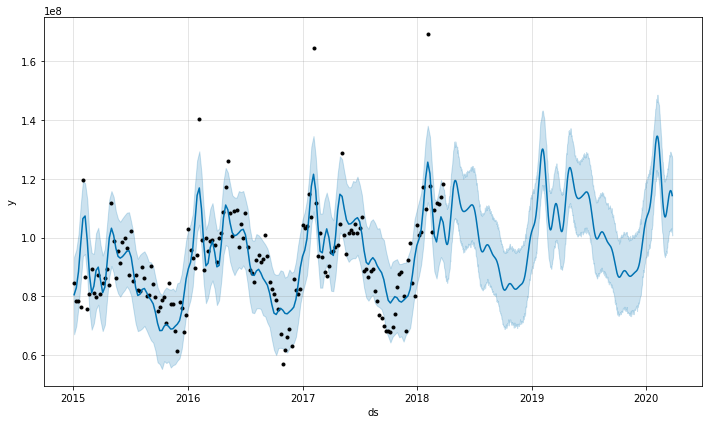

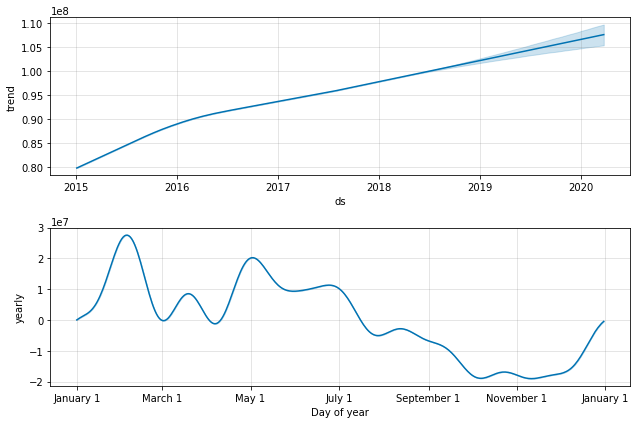

In [40]:
#plotting forecast and actual values 
model.plot(forecast);

#plotting the total trend and seasonality
model.plot_components(forecast);


In [49]:
#create a cross validation with cuffoffs at feb 13 2017 and december 25 2017
cross_val= cross_validation(model, horizon= '90 days', period = '45 days', initial = '730 days')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2017-02-13 00:00:00 and 2017-12-25 00:00:00


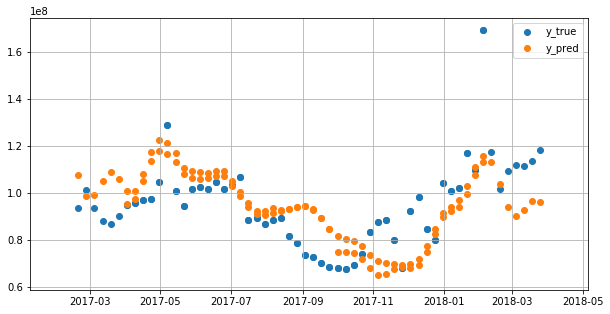

In [71]:
#plot cross validation y true and y pred
fig= plt.figure(figsize=(10,5))
plt.scatter(cross_val['ds'], cross_val['y'], label='y_true')
plt.scatter(cross_val['ds'], cross_val['yhat'], label= 'y_pred')
plt.grid()
plt.legend()

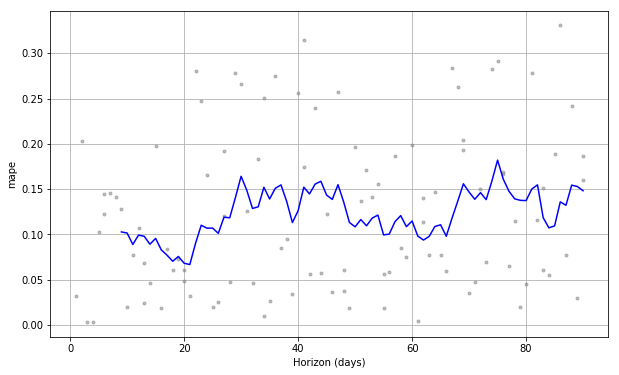

In [67]:
#looked at different error stats
performance_cv= performance_metrics(cross_val)
#plot cross validation metric
plot_cross_validation_metric(cross_val, metric='mape');

### Stretch Goal
- Adjust your forecasts with Prophet's options for changepoints, holidays, and fourier order. Improve the cross-validation MAPE.

## Part 2. Predict NYC apartment rent 🏠💸

For part 1 of your challenge, you'll use a real-world data with rent prices for a subset of apartments in New York City!

Run this code cell to load the dataset: 

In [0]:
import pandas as pd
rent_url = 'https://drive.google.com/uc?export=download&id=1lVVPmh-WYGb_0Gs_lOv22i02-150qDdZ'
rent = pd.read_csv(rent_url)
assert rent.shape == (48295, 7)

In [131]:
#checking out data
rent.isna().sum()
rent.month.unique()
rent.describe()

Mean absolute error of mean baseline is: 1055.7857771080928


In [141]:
#Added mean baseline column to df
rent['mean_baseline']= rent['price'].mean()

#found the mean absolute error of mean baseline and printed it
mae= mean_absolute_error(rent['price'], rent['mean_baseline'])
r2= r2_score(rent['price'], rent['mean_baseline'])
print('Mean absolute error of mean baseline is: '+ str(mae))
print('r squared score of mean baseline is: '+ str(r2))

Mean absolute error of mean baseline is: 1055.7857771080928
r squared score of mean baseline is: 0.0


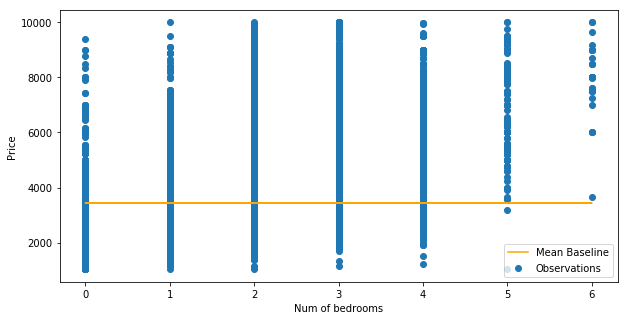

In [134]:
#plotting real ys and mean baseline
fig= plt.figure(figsize= (10,5))
plt.scatter('bedrooms', 'price', data=rent, label= 'Observations')
plt.plot('bedrooms', 'mean_baseline', data= rent, color='orange', label='Mean Baseline')

#cosmetics
plt.legend()
plt.xlabel('Num of bedrooms')
plt.ylabel('Price');

In [0]:
#Set months
months= [4, 5]

#split train and test data by months
train= rent[rent['month'].isin(months)]
test= rent[rent['month']== 6]

#set features and target
features= ['bedrooms', 'bathrooms']
target= 'price'

#setting train xs and ys 
X_train= train[features]
y_train= train[target]

#set test xs and ys
X_test= test[features]
y_test= test[target]

In [143]:
#create model
model= LinearRegression()

#fit training data to model
model.fit(X_train, y_train)

#generate predictions for xtest
y_pred= model.predict(X_test)

#calculate mean absolute error and r squared error for y_pred and y_test
mae= mean_absolute_error(y_test, y_pred)
r_squared= r2_score(y_test, y_pred)

#grabbed coefficients and intercept for model
bedroom_coef, bathroom_coef= model.coef_
intercept= model.intercept_

#Print errors, coef for each feature, and intercept
print('Mean absolute error: '+ str(mae))
print('R squared score: '+ str(r_squared))
print('Bedroom coef: '+ str(bedroom_coef))
print('Bathroom coef: ' + str(bathroom_coef))
print('Intercept: '+ str(intercept))

Mean absolute error: 754.0733041489015
R squared score: 0.4613584851907725
Bedroom coef: 420.50971680242264
Bathroom coef: 1531.7626475309855
Intercept: 994.3062975058142


### Required
1. Begin with baselines for regression. Calculate the mean absolute error and $R^2$ score for a mean baseline. _(You can use the whole dataset, or a test set, either way is okay here!)_
2. Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
3. Choose any two features.
4. Use scikit-learn to fit a Linear Regression model on the train data.
5. Apply the model to predict rent prices for the test data.
6. Get regression metrics MAE and $R^2$ for the test data.
7. Get the model's coefficients and intercept.

### Stretch Goals
- Try at least 3 different feature combinations. (You don't have to use two features, you can choose any number of features.)
- Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.

In [187]:
features= ['bedrooms', 'bathrooms', 'latitude', 'longitude']
target= 'price'
#for loop to test models errors based on amount of features
for num in range(0, 4):
  X_train= train[features[0:num+1]]
  y_train= train[target]
  X_test= test[features[0:num+1]]
  y_test= test[target]
  model= LinearRegression()
  model.fit(X_train, y_train)
  y_pred= model.predict(X_test)
  mae= mean_absolute_error(y_test, y_pred)
  r2= r2_score(y_test, y_pred)
  rmse= np.sqrt(mean_squared_error(y_test, y_pred))
  print('Root mean squared error for '+ str(features[0:num+1])+ ' is :'+ str(rmse))
  print('Mean absolute error for '+ str(features[0:num+1]) + ' is :' + str(mae))
  print('R squared score for ' + str(features[0:num+1]) + ' is :' +str(r2))

Root mean squared error for ['bedrooms'] is :1180.3415389364188
Mean absolute error for ['bedrooms'] is :865.6211073158057
R squared score for ['bedrooms'] is :0.2951496125455565
Root mean squared error for ['bedrooms', 'bathrooms'] is :1031.832329739043
Mean absolute error for ['bedrooms', 'bathrooms'] is :754.0733041489015
R squared score for ['bedrooms', 'bathrooms'] is :0.4613584851907725
Root mean squared error for ['bedrooms', 'bathrooms', 'latitude'] is :1028.3411023863457
Mean absolute error for ['bedrooms', 'bathrooms', 'latitude'] is :746.7235225517642
R squared score for ['bedrooms', 'bathrooms', 'latitude'] is :0.46499732949782924
Root mean squared error for ['bedrooms', 'bathrooms', 'latitude', 'longitude'] is :928.5485606974506
Mean absolute error for ['bedrooms', 'bathrooms', 'latitude', 'longitude'] is :667.6543093383528
R squared score for ['bedrooms', 'bathrooms', 'latitude', 'longitude'] is :0.5637948359714793
